In [ ]:
!pip install tensorflow pillow matplotlib albumentations

In [ ]:
# Dossiers pour les vraies cartes, les fakes, les augmentées, le modèle et les utilitaires
!mkdir -p data/raw/ids/real
!mkdir -p data/test/fake
!mkdir -p data_augmented/real
!mkdir -p utils
!mkdir -p models

In [ ]:
%%writefile utils/augmentation_utils.py
import os, numpy as np
from PIL import Image

def augment_image_folder(input_dir, output_dir, pipeline, num_augmented_per_image=5):
    os.makedirs(output_dir, exist_ok=True)
    for fname in os.listdir(input_dir):
        if not fname.lower().endswith(('.png','.jpg','.jpeg')):
            continue
        img = np.array(Image.open(os.path.join(input_dir, fname)))
        base, _ = os.path.splitext(fname)
        for i in range(num_augmented_per_image):
            aug = pipeline(image=img)['image']
            Image.fromarray(aug).save(os.path.join(output_dir, f"{base}_aug{i}.png"))

Writing utils/augmentation_utils.py


In [ ]:
%%writefile utils/anomaly_utils.py
import numpy as np
import tensorflow as tf

def build_autoencoder(input_shape=(128,128,3), latent_dim=64):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(inputs)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Flatten()(x)
    latent = tf.keras.layers.Dense(latent_dim, activation='relu')(x)
    x = tf.keras.layers.Dense(64*64*64, activation='relu')(latent)
    x = tf.keras.layers.Reshape((64,64,64))(x)
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2DTranspose(32,3,activation='relu',padding='same')(x)
    x = tf.keras.layers.UpSampling2D()(x)
    outputs = tf.keras.layers.Conv2D(3,3,activation='sigmoid',padding='same')(x)
    return tf.keras.Model(inputs, outputs)

def train_autoencoder(model, X, epochs=20, batch_size=32, validaStion_split=0.1):
    model.compile(optimizer='adam', loss='mse')
    return model.fit(X, X,
                     epochs=epochs,
                     batch_size=batch_size,
                     validation_split=validation_split)

def compute_anomaly_scores(model, X):
    recon = model.predict(X)
    return np.mean(np.square(X - recon), axis=(1,2,3))

Writing utils/anomaly_utils.py


In [ ]:
from google.colab import files
# Dans l’UI, clique “Choose Files” et sélectionne tes real_*.png et fake_*.png
files.upload()

Saving fake_01.png to fake_01.png
Saving fake_02.png to fake_02.png
Saving fake_03.png to fake_03.png
Saving fake_04.png to fake_04.png
Saving fake_05.png to fake_05.png
Saving real_01.png to real_01.png
Saving real_02.gif to real_02.gif
Saving real_03.jpg to real_03.jpg
Saving real_04.jpg to real_04.jpg
Saving real_05.jpg to real_05.jpg
Saving real_06.jpg to real_06.jpg
Saving real_07.jpg to real_07.jpg
Saving real_08.jpg to real_08.jpg
Saving real_09.jpg to real_09.jpg
Saving real_10.jfif to real_10.jfif
Buffered data was truncated after reaching the output size limit.

In [ ]:
!mv real_01.png data/raw/ids/real/
!mv real_02.gif data/raw/ids/real/
!mv real_03.jpg data/raw/ids/real/
!mv real_04.jpg data/raw/ids/real/
!mv real_05.jpg data/raw/ids/real/
!mv real_06.jpg data/raw/ids/real/
!mv real_07.jpg data/raw/ids/real/
!mv real_08.jpg data/raw/ids/real/
!mv real_09.jpg data/raw/ids/real/
!mv real_10.jfif data/raw/ids/real/
!mv fake_01.png data/test/fake/
!mv fake_02.png data/test/fake/
!mv fake_03.png data/test/fake/
!mv fake_04.png data/test/fake/
!mv fake_05.png data/test/fake/
!ls data/raw/ids/real
!ls data/test/fake

real_01.png  real_03.jpg  real_05.jpg  real_07.jpg  real_09.jpg
real_02.gif  real_04.jpg  real_06.jpg  real_08.jpg  real_10.jfif
fake_01.png  fake_02.png  fake_03.png  fake_04.png  fake_05.png


In [ ]:
import os, numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow as tf

# Importer nos utilitaires
from utils.augmentation_utils import augment_image_folder
from utils.anomaly_utils    import build_autoencoder, train_autoencoder, compute_anomaly_scores

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


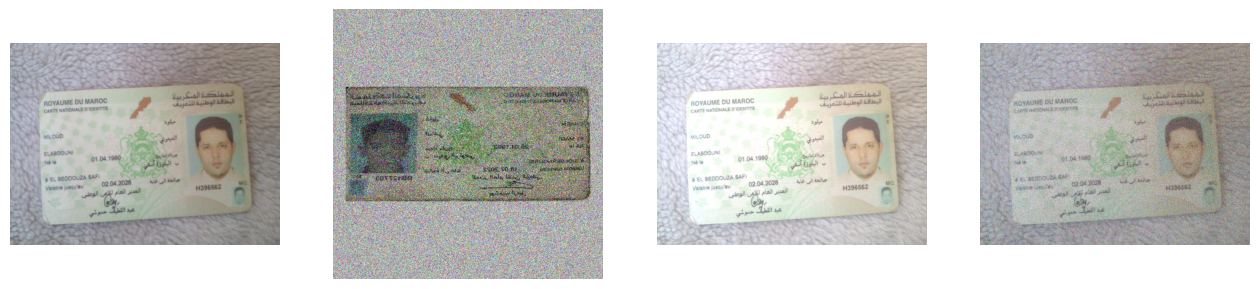

In [ ]:
pipeline = A.Compose([
    A.HorizontalFlip(), A.RandomBrightnessContrast(),
    A.GaussianBlur(), A.ShiftScaleRotate(0.02,0.1,15),
    A.GaussNoise()
])
augment_image_folder("data/raw/ids/real", "data_augmented/real",
                     pipeline, num_augmented_per_image=5)

# Afficher quelques exemples
sample = glob("data_augmented/real/*.png")[:4]
fig, axes = plt.subplots(1,4,figsize=(16,4))
for ax, p in zip(axes, sample):
    ax.imshow(np.array(Image.open(p))); ax.axis('off')
plt.show()

In [ ]:
def load_images(paths, size=(128,128)):
    arr = []
    for p in paths:
        # 1) Ouvrir et forcer en RGB (3 canaux)
        img = Image.open(p).convert("RGB")
        # 2) Redimensionner
        img = img.resize(size)
        # 3) Convertir en array (H, W, 3) et normaliser
        arr.append(np.array(img) / 255.0)
    # 4) Empiler : tous les tableaux ont maintenant la même shape
    return np.stack(arr)

# Puis appel comme avant
X_train = load_images(glob("data_augmented/real/*.png"))
print("X_train.shape =", X_train.shape)

X_train.shape = (40, 128, 128, 3)


In [ ]:
# 1️⃣ Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# 2️⃣ Définition de l’autoencodeur (128→64→32 puis 32→64→128)
def build_autoencoder(input_shape=(128,128,3), latent_dim=64):
    inputs = tf.keras.Input(shape=input_shape)
    # ENCODER
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)   # 128×128×32
    x = layers.MaxPool2D()(x)                                            # 64×64×32
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)       # 64×64×64
    x = layers.MaxPool2D()(x)                                            # 32×32×64
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, activation='relu')(x)
    # DECODER
    x = layers.Dense(32*32*64, activation='relu')(latent)
    x = layers.Reshape((32,32,64))(x)                                     # 32×32×64
    x = layers.UpSampling2D()(x)                                          # 64×64×64
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)  # 64×64×32
    x = layers.UpSampling2D()(x)                                          # 128×128×32
    outputs = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)  # 128×128×3
    return tf.keras.Model(inputs, outputs)

# 3️⃣ Fonction d’entraînement
def train_autoencoder(model, X, epochs=20, batch_size=32, validation_split=0.1):
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(
        X, X,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        verbose=2
    )
    return history

# 4️⃣ Construction et entraînement
ae = build_autoencoder(input_shape=(128,128,3), latent_dim=64)
history = train_autoencoder(
    ae,
    X_train,          # tableau numpy de shape (N,128,128,3)
    epochs=20,
    batch_size=32,
    validation_split=0.1
)

# 5️⃣ Sauvegarde du modèle
os.makedirs("models", exist_ok=True)
ae.save("models/autoencoder_id.h5")

# 6️⃣ Affichage des dernières valeurs de perte
print(f"→ Perte d'entraînement finale : {history.history['loss'][-1]:.4f}")
print(f"→ Perte de validation finale : {history.history['val_loss'][-1]:.4f}")

Epoch 1/20
2/2 - 6s - 3s/step - loss: 0.0740 - val_loss: 0.0857
Epoch 2/20
2/2 - 5s - 2s/step - loss: 0.0697 - val_loss: 0.0506
Epoch 3/20
2/2 - 3s - 1s/step - loss: 0.0463 - val_loss: 0.0435
Epoch 4/20
2/2 - 3s - 2s/step - loss: 0.0545 - val_loss: 0.0397
Epoch 5/20
2/2 - 4s - 2s/step - loss: 0.0419 - val_loss: 0.0521
Epoch 6/20
2/2 - 2s - 1s/step - loss: 0.0475 - val_loss: 0.0488
Epoch 7/20
2/2 - 5s - 3s/step - loss: 0.0451 - val_loss: 0.0388
Epoch 8/20
2/2 - 6s - 3s/step - loss: 0.0406 - val_loss: 0.0356
Epoch 9/20
2/2 - 7s - 4s/step - loss: 0.0424 - val_loss: 0.0353
Epoch 10/20
2/2 - 3s - 1s/step - loss: 0.0422 - val_loss: 0.0359
Epoch 11/20
2/2 - 4s - 2s/step - loss: 0.0399 - val_loss: 0.0393
Epoch 12/20
2/2 - 3s - 1s/step - loss: 0.0402 - val_loss: 0.0361
Epoch 13/20
2/2 - 2s - 1s/step - loss: 0.0390 - val_loss: 0.0350
Epoch 14/20
2/2 - 2s - 1s/step - loss: 0.0411 - val_loss: 0.0354
Epoch 15/20
2/2 - 3s - 2s/step - loss: 0.0398 - val_loss: 0.0388
Epoch 16/20
2/2 - 4s - 2s/step - l

→ Perte d'entraînement finale : 0.0384
→ Perte de validation finale : 0.0373


In [ ]:
import numpy as np
import tensorflow as tf
from glob import glob

# Vous devez déjà avoir défini load_images et compute_anomaly_scores
# (depuis les cellules précédentes ou inline).

# 1) Charger le modèle *sans* compiler pour éviter l’erreur “Could not locate function 'mse'”
ae = tf.keras.models.load_model("models/autoencoder_id.h5", compile=False)

# 2) Récupérer les chemins des images de test
real_paths = glob("data/raw/ids/real/*.png")
fake_paths = glob("data/test/fake/*.png")

# 3) Charger les images au bon format (128×128×3)
X_real_test = load_images(real_paths)
X_fake_test = load_images(fake_paths)

# 4) Calculer les scores d’anomalie (MSE reconstruction)
scores_real = compute_anomaly_scores(ae, X_real_test)
scores_fake = compute_anomaly_scores(ae, X_fake_test)

# 5) Afficher les moyennes
print("Moyenne score real :", np.mean(scores_real))
print("Moyenne score fake :", np.mean(scores_fake))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Moyenne score real : 0.060486617756840076
Moyenne score fake : 0.06621126612951317


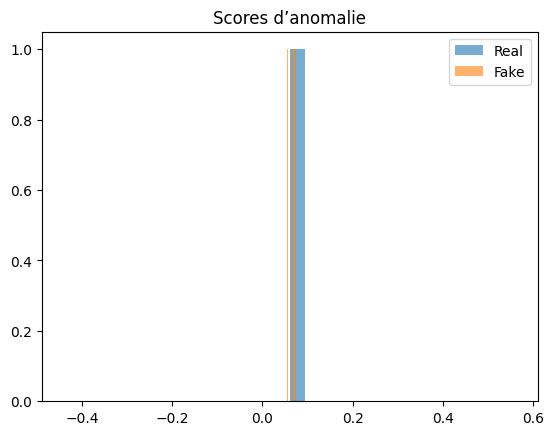

In [ ]:
plt.hist(scores_real, bins=30, alpha=0.6, label="Real")
plt.hist(scores_fake, bins=30, alpha=0.6, label="Fake")
plt.legend(); plt.title("Scores d’anomalie"); plt.show()


In [ ]:
import numpy as np
from glob import glob
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1) Récupérer les chemins
real_test_paths = sorted(glob("data/test/real/*.*"))
fake_test_paths = sorted(glob("data/test/fake/*.*"))

# 2) Charger les images
X_real_test = load_images(real_test_paths)   # (N_real, 128,128,3)
X_fake_test = load_images(fake_test_paths)   # (N_fake, 128,128,3)

# 3) Calculer les scores d’anomalie
scores_real_test = compute_anomaly_scores(ae, X_real_test)
scores_fake_test = compute_anomaly_scores(ae, X_fake_test)

# 4) Sélectionner un seuil (ici midpoint sur les moyennes)
seuil = (scores_real_test.mean() + scores_fake_test.mean()) / 2
print(f"Seuil choisi = {seuil:.4f}\n")

# 5) Construire les labels et prédictions
y_true = np.array([0]*len(scores_real_test) + [1]*len(scores_fake_test))
y_scores = np.concatenate([scores_real_test, scores_fake_test])
y_pred   = (y_scores > seuil).astype(int)

# 6) Afficher métriques globales
print("▶ Accuracy :", accuracy_score(y_true, y_pred))
print("\n▶ Matrice de confusion :\n", confusion_matrix(y_true, y_pred))
print("\n▶ Rapport de classification :\n", classification_report(y_true, y_pred, target_names=["Real","Fake"]))

# 7) Afficher verdict image par image
print("\n▶ Détails par image :")
for path, pred, score in zip(real_test_paths+fake_test_paths, y_pred, y_scores):
    label = "Fake" if pred==1 else "Real"
    print(f"{path.split('/')[-1]:20s} → score={score:.4f} → {label}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Seuil choisi = 0.0505

▶ Accuracy : 1.0

▶ Matrice de confusion :
 [[5 0]
 [0 5]]

▶ Rapport de classification :
               precision    recall  f1-score   support

        Real       1.00      1.00      1.00         5
        Fake       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10


▶ Détails par image :
real_test01.jpg      → score=0.0416 → Real
real_test02.jpg      → score=0.0472 → Real
real_test03.jpg      → score=0.0490 → Real
real_test04.png      → score=0.0231 → Real
real_test05.png      → score=0.0127 → Real
fake_01.png          → score=0.0667 → Fake
fake_02.png          → score=0.0551 → Fake
fake_03.png          → score=0.0642 → Fake
fake_04.png          → score=0.0712 → Fake
fake_05.png          → score=0.0739 → Fake


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/KYC_vLLM
!cp -r /content/data /content/utils /content/models /content/data_augmented /content/drive/MyDrive/KYC_vLLM/

In [ ]:
%cd /content/drive/MyDrive/KYC_vLLM

/content/drive/MyDrive/KYC_vLLM
